In [7]:
#!cd /hdd_mnt/onurcan/onurk/datasets/train/&&ls -d */ | xargs -I {} mkdir -p /hdd_mnt/onurcan/onurk/datasets/train_multioutput_robust_hio_alpha_3/{}

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random
import torchvision
import torch.autograd as autograd
import time
from tqdm import tqdm

from models.denoisers import get_denoiser

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 32

root = "/hdd_mnt/onurcan/onurk/datasets/"
stage = "train"
save_path = f"{stage}_multioutput_robust_hio_alpha_3"

test_dataloader = get_loader("noise_amplitude_dataset", stage, root, batch_size=batch_size, alpha=3)

image_paths = sorted(
            (Path(root) / Path(stage)).rglob(["*.png", "*.jpg", "*.jpeg", "*.bmp"])
        )


In [2]:
selected_indices_dataloader = list(range(3000)) + [random.randrange(len(test_dataloader.dataset)) for _ in range(43000)]

In [3]:
test_dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataloader.dataset, selected_indices_dataloader), batch_size=batch_size)

In [4]:
image_paths = [image_paths[i] for i in selected_indices_dataloader]

In [5]:
len(test_dataloader)*32

46016

In [6]:
len(image_paths)

46000

In [7]:
save_index = 0

with torch.no_grad():
    for test_i, (im, am, sp) in tqdm(enumerate(test_dataloader)):
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)

        # Developed algorithm
        start_time = time.time()
        top_k = 10
        g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=100, top_k=top_k, use_tqdm=False)
        end_time = time.time()
        # print(f"Time: {end_time - start_time}")

        im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
        g_cropped_normalized = crop_center_half(g)
        
        im_cropped_normalized_repeated = repeat(
            im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
        )

        all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
        robust_output = all_mse_loss_corrected[0] # * 255
        robust_output = robust_output.to(device).float()
        
        # clip between 0-255
        robust_output = torch.clip(robust_output, 0, 255)        
        
        robust_output = robust_output.squeeze().cpu().detach().numpy()
        
        # save
        for plt_g in robust_output:
            np.save(f"{Path(root) / save_path / image_paths[save_index].relative_to(Path(root) / stage)}", plt_g)
            save_index += 1
            
        
        
        # subplots
        # fig, axs = plt.subplots(1, robust_output.shape[1], figsize=(15, 15))
        # for j in range(robust_output.shape[1]):
        #     axs[j].imshow(robust_output[0][j], cmap="gray")
        #     axs[j].axis("off")
        # plt.show()
        
        # if test_i>9:
        #     break
    

0it [00:00, ?it/s]

7it [03:41, 31.51s/it]

In [16]:
!ls datasets/test_multioutput_robust_hio_alpha_3

test_0_robust_output.npy   test_3_robust_output.npy  test_7_robust_output.npy
test_10_robust_output.npy  test_4_robust_output.npy  test_8_robust_output.npy
test_1_robust_output.npy   test_5_robust_output.npy  test_9_robust_output.npy
test_2_robust_output.npy   test_6_robust_output.npy


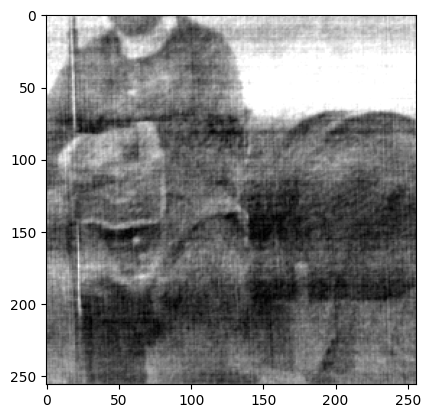

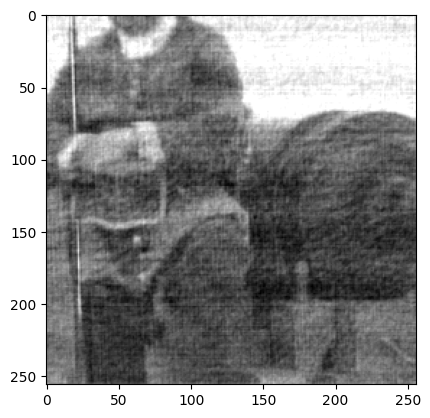

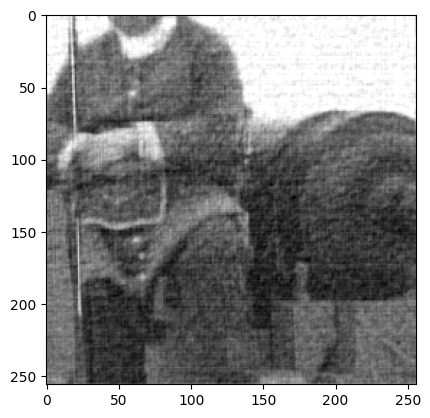

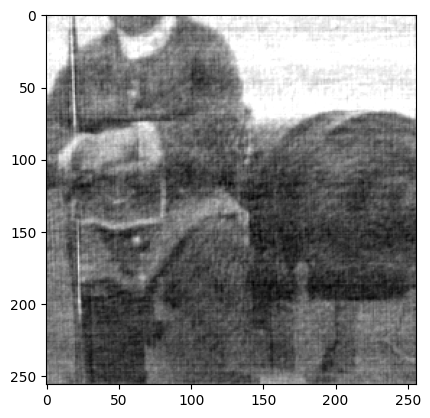

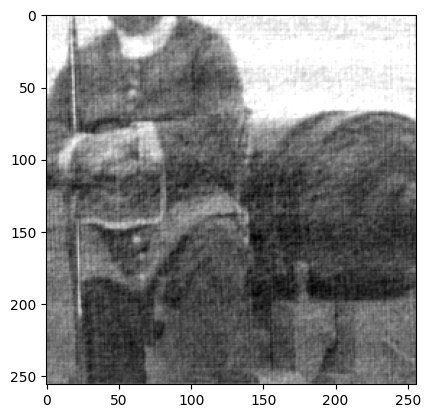

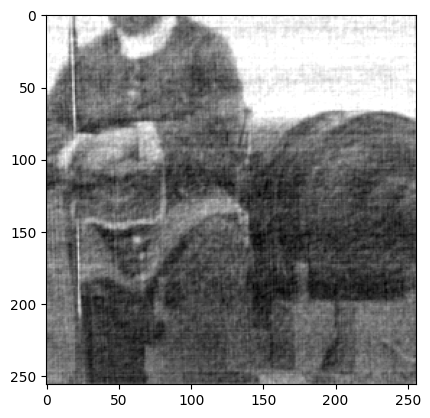

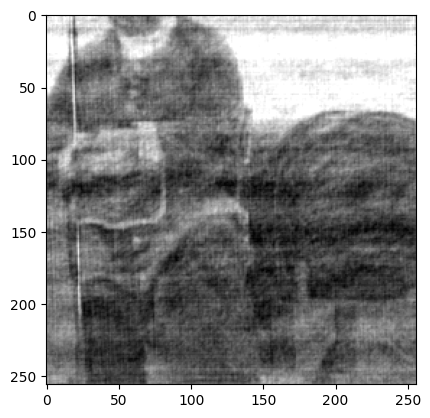

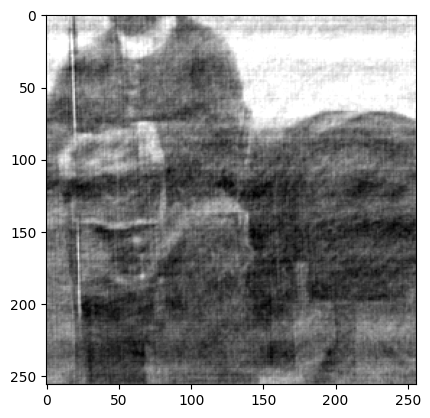

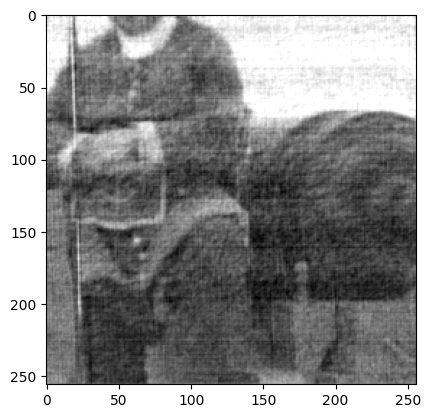

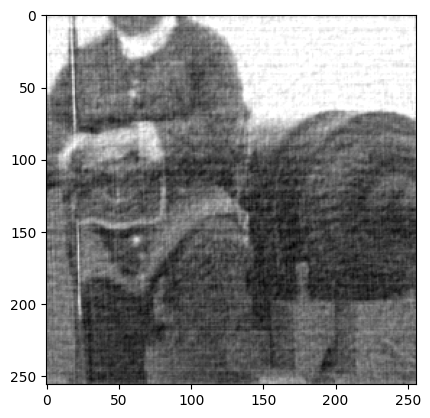

In [8]:
load_try = np.load("/hdd_mnt/onurcan/onurk/datasets/test_multioutput_robust_hio_alpha_3/109.png.npy")
for ch in load_try:
    plt.imshow(ch, cmap="gray")
    plt.show()

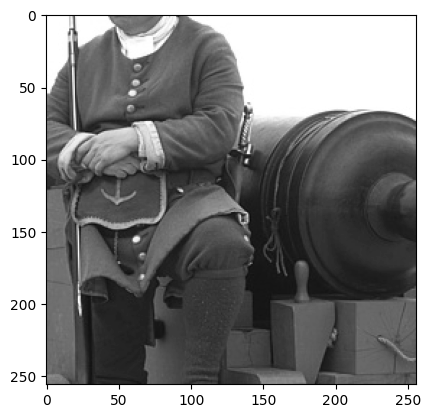

In [9]:
orig_image_try = cv2.imread("/hdd_mnt/onurcan/onurk/datasets/test/109.png", cv2.IMREAD_GRAYSCALE)
# plot
plt.imshow(orig_image_try, cmap="gray")
plt.show()

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random
import torchvision
import torch.autograd as autograd

from models.denoisers import get_denoiser

In [3]:
root = "/hdd_mnt/onurcan/onurk/datasets/adversarial_alpha_3"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 1
stage = "val"
val_dataloader = get_loader("adversarial_dataset", stage, root, batch_size)
stage = "test"
test_dataloader = get_loader("adversarial_dataset", stage, root, batch_size)

In [ ]:
for index_dataloader, (target_im, robust_output, output) in enumerate(test_dataloader):
    # visualize them
    target_im = target_im.to(device)
    robust_output = robust_output.to(device)
    output = output.to(device)
    target_im = target_im.squeeze()
    robust_output = robust_output.squeeze()
    output = output.squeeze()
    target_im = target_im.cpu().detach().numpy()
    robust_output = robust_output.cpu().detach().numpy()
    output = output.cpu().detach().numpy()
    # subplots for
    # for target, robust_output, output
    # for absolute differences output - target, robust_output - target
    # for related absolute differences on top of output and robust_output (mixed)
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs[0, 0].imshow(target_im, cmap="gray")
    axs[0, 0].set_title("Target")
    axs[0, 1].imshow(robust_output, cmap="gray")
    axs[0, 1].set_title("Robust Output")
    axs[0, 2].imshow(output, cmap="gray")
    axs[0, 2].set_title("Output")
    
    axs[2, 1].imshow(np.abs(target_im - robust_output), cmap="gray")
    axs[2, 2].imshow(np.abs(target_im - output), cmap="gray")
    
    difference_output = 5*np.abs(target_im - output)
    difference_robust_output = 5*np.abs(target_im - robust_output)
    
    axs[1, 1].imshow(np.stack((robust_output+difference_robust_output, robust_output-difference_robust_output, robust_output-difference_robust_output), axis=-1), cmap="gray")
    axs[1, 2].imshow(np.stack((output+difference_output, output-difference_output, output-difference_output), axis=-1), cmap="gray")
    plt.show()

In [4]:
from tqdm import tqdm
import time
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio
import logging
import pickle
from einops import rearrange, repeat


In [20]:
stage = "test"
root = "/hdd_mnt/onurcan/onurk/datasets/"

test_dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size=1, alpha=3)

In [ ]:
with torch.no_grad():
    for im, am, sp, robust_output in test_dataloader:
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)
        robust_output = robust_output.to(device).float()

        # Developed algorithm
        n_tries = 10
        repeat_am = repeat(am, 'b c h w -> (b r) c h w', r=10)
        repeat_sp = repeat(sp, 'b c h w -> (b r) c h w', r=10)
        repeat_im = repeat(im, 'b c h w -> (b r) c h w', r=10)
        
        g, _ = get_algorithm("RobustHIO")(repeat_am, repeat_sp, use_tqdm=False)
    
        im_cropped_normalized = normalize(crop_center_half(repeat_im)) # normalize decreases the metrics
        g_cropped_normalized = normalize(crop_center_half(g))
        all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized)
        robust_output = all_mse_loss_corrected[0] * 255
        robust_output = robust_output.to(device).float()
        
        # visualize robust_output as subplots
        robust_output = robust_output.squeeze()
        robust_output = robust_output.cpu().detach().numpy()
        #subplots
        fig, axs = plt.subplots(1, n_tries, figsize=(40, 40))
        for i in range(10):
            axs[i].imshow(robust_output[i], cmap="gray")
            axs[i].axis("off")
        plt.show()
        


In [14]:
len(test_dataloader)

236

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import sys
sys.path.append("..")

from dataloaders.dataloader_v1 import get_loader
import torch
from wcmatch.pathlib import Path
from utils.utils import crop_center_half, ifft2d, normalize, flip_to_minimize_loss
from utils.algorithms import get_algorithm
from matplotlib import pyplot as plt
from einops import rearrange, repeat
import cv2
import numpy as np
import random
import torchvision
import torch.autograd as autograd
import time

from models.denoisers import get_denoiser

In [2]:
root = "/hdd_mnt/onurcan/onurk/datasets/adversarial_alpha_3"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 1

stage = "test"
root = "/hdd_mnt/onurcan/onurk/datasets/"

test_dataloader = get_loader("noise_amplitude_with_robust_hio_dataset", stage, root, batch_size=batch_size, alpha=3)

In [12]:
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio

with torch.no_grad():
    for different_random_count in range(50, 180, 20):
        psnr_hio_list = np.array([])
        psnr_hio_list_min = np.array([])
        for test_i, (im, am, sp, robust_output) in enumerate(test_dataloader):
            im = im.to(device)
            am = am.to(device)
            sp = sp.to(device)
            robust_output = robust_output.to(device).float()

            # Developed algorithm
            start_time = time.time()
            top_k = 10
            g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=different_random_count, top_k=top_k, use_tqdm=False)
            end_time = time.time()
            # print(f"Time: {end_time - start_time}")

            im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
            g_cropped_normalized = crop_center_half(g)
            
            im_cropped_normalized_repeated = repeat(
                im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
            )

            all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
            robust_output = all_mse_loss_corrected[0] # * 255
            robust_output = robust_output.to(device).float()
            
            psnr_hio = peak_signal_noise_ratio(robust_output, im_cropped_normalized_repeated, data_range=255, reduction="none", dim=(2,3)).cpu()
            psnr_hio_list = np.append(psnr_hio_list, psnr_hio.max())
            psnr_hio_list_min = np.append(psnr_hio_list_min, psnr_hio.min())
            
            # # visualize robust_output as subplots
            # robust_output = robust_output.cpu().detach().numpy()
            # #subplots
            # fig, axs = plt.subplots(1, robust_output.shape[1], figsize=(15, 15))
            # for j in range(robust_output.shape[1]):
            #     axs[j].imshow(robust_output[0][j], cmap="gray")
            #     axs[j].axis("off")
            # plt.show()
            
            if test_i>25:
                break
        
        # print(psnr_hio_list)
        print(different_random_count, psnr_hio_list.mean(), psnr_hio_list.min(), psnr_hio_list_min.mean(), psnr_hio_list_min.min())
        print("=====================================")


50 22.955810334947373 17.016250610351562 20.18364867457637 12.786806106567383
70 22.938413196139866 17.97953987121582 20.476792406152796 13.537078857421875
90 23.115712695651585 17.730392456054688 20.907966401841904 14.279534339904785
110 23.0067463627568 17.816953659057617 20.19953794832583 13.374277114868164
130 23.057319358543115 18.097383499145508 21.2011909838076 14.1463041305542
150 23.132714165581596 17.373249053955078 20.60986833219175 14.090953826904297
170 23.060374719125253 18.117380142211914 21.22119825857657 14.476853370666504


In [24]:
!ls datasets

adversarial_alpha_3		     train_multioutput_robust_hio_alpha_3
imagenet-256.zip		     train_robust_hio_alpha_3
test				     train_robust_hio_alpha_3_old
test_hio_alpha_3		     val
test_multioutput_robust_hio_alpha_3  val_hio_alpha_3
test_robust_hio_alpha_3		     val_multioutput_robust_hio_alpha_3
test_robust_hio_alpha_3_old	     val_robust_hio_alpha_3
train				     val_robust_hio_alpha_3_old
train_hio_alpha_3


In [23]:
!mkdir datasets/train_multioutput_robust_hio_alpha_3

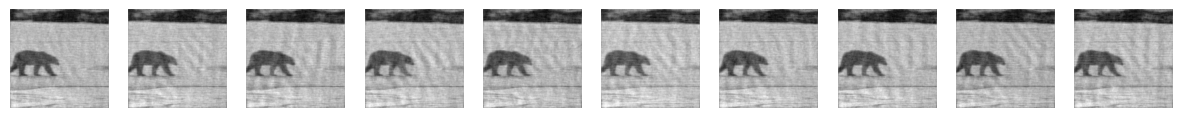

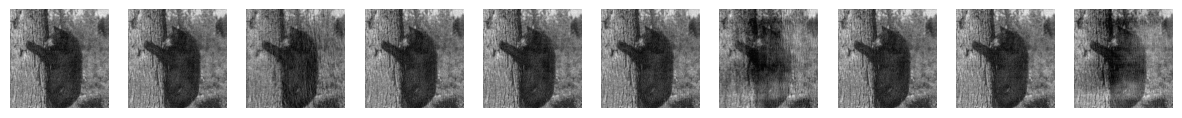

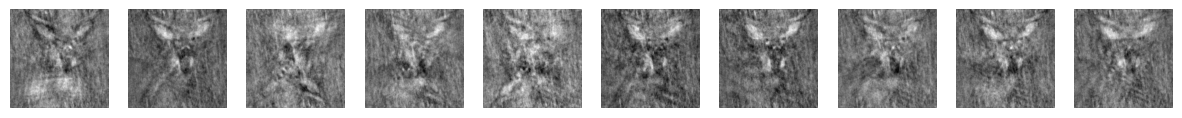

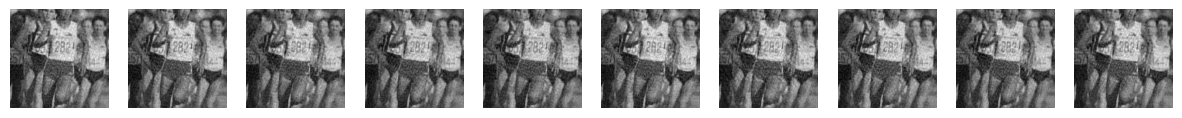

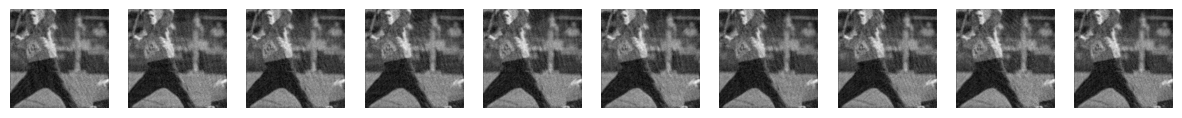

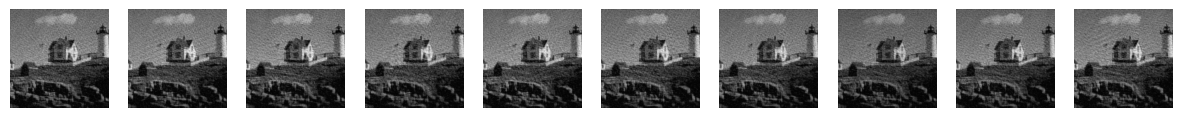

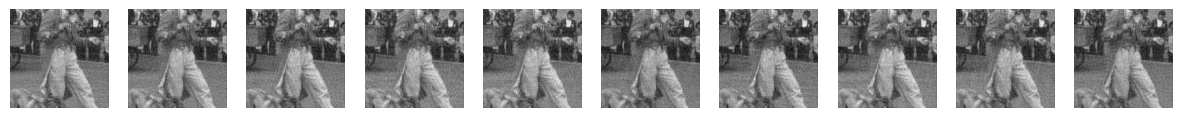

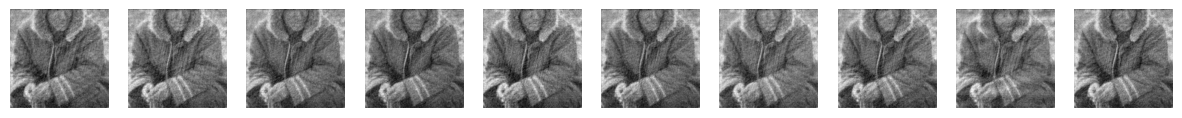

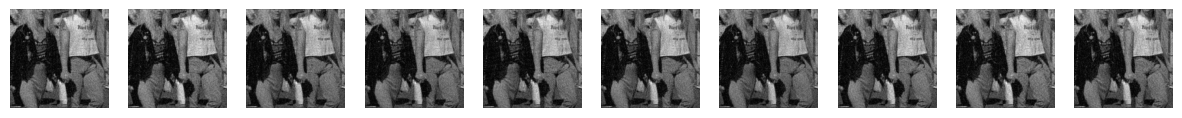

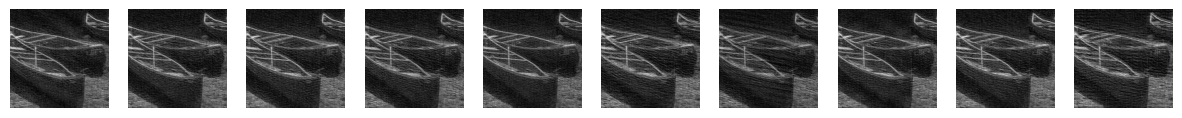

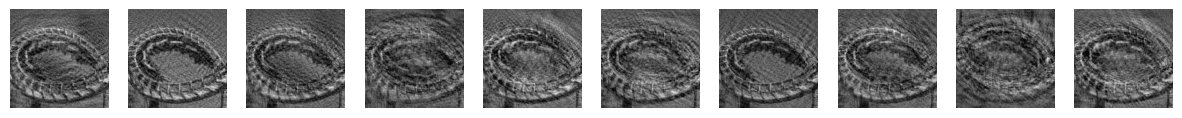

100 22.545535174283113 17.74123764038086 20.521826830777254 13.170287132263184


In [16]:
from torchmetrics.functional.image import structural_similarity_index_measure, peak_signal_noise_ratio

with torch.no_grad():
    psnr_hio_list = np.array([])
    psnr_hio_list_min = np.array([])
    for test_i, (im, am, sp, robust_output) in enumerate(test_dataloader):
        im = im.to(device)
        am = am.to(device)
        sp = sp.to(device)
        robust_output = robust_output.to(device).float()

        # Developed algorithm
        start_time = time.time()
        top_k = 10
        g, _ = get_algorithm("MultiOutputRobustHIO")(am, sp, different_random_count=100, top_k=top_k, use_tqdm=False)
        end_time = time.time()
        # print(f"Time: {end_time - start_time}")

        im_cropped_normalized = crop_center_half(im) # normalize decreases the metrics
        g_cropped_normalized = crop_center_half(g)
        
        im_cropped_normalized_repeated = repeat(
            im_cropped_normalized, "b c h w -> b (repeat c) h w", repeat=top_k
        )

        all_mse_loss_corrected = flip_to_minimize_loss(g_cropped_normalized, im_cropped_normalized_repeated)
        robust_output = all_mse_loss_corrected[0] # * 255
        robust_output = robust_output.to(device).float()
        
        psnr_hio = peak_signal_noise_ratio(robust_output, im_cropped_normalized_repeated, data_range=255, reduction="none", dim=(2,3)).cpu()
        psnr_hio_list = np.append(psnr_hio_list, psnr_hio.max())
        psnr_hio_list_min = np.append(psnr_hio_list_min, psnr_hio.min())
        
        # visualize robust_output as subplots
        robust_output = robust_output.cpu().detach().numpy()
        # subplots
        fig, axs = plt.subplots(1, robust_output.shape[1], figsize=(15, 15))
        for j in range(robust_output.shape[1]):
            axs[j].imshow(robust_output[0][j], cmap="gray")
            axs[j].axis("off")
        plt.show()
        
        if test_i>9:
            break
    
    # print(psnr_hio_list)
    print(100, psnr_hio_list.mean(), psnr_hio_list.min(), psnr_hio_list_min.mean(), psnr_hio_list_min.min())
    print("=====================================")


torch.Size([1, 10])

tensor(26.1445)

In [27]:
robust_output.shape

torch.Size([1, 10, 256, 256])

In [24]:
im_cropped_normalized_repeated.shape

torch.Size([1, 10, 256, 256])

In [26]:
robust_output[0].shape

(10, 256, 256)

In [5]:
print(g.shape)

torch.Size([5, 10, 512, 512])


In [7]:
amplitude_repeated = repeat(
    am, "b c h w -> b (repeat c) h w", repeat=13
)
print(amplitude_repeated.shape)

torch.Size([5, 13, 512, 512])


In [10]:
g.shape

torch.Size([1, 10, 512, 512])

In [31]:
robust_output.shape

torch.Size([10, 1, 256, 256])

In [10]:
def random_best(
    amplitude: torch.Tensor,
    support: torch.Tensor,
    algorithm: str = "HIO",
    iterations: int = 50,
    different_random_count: int = 50,
    use_tqdm: bool = True,
):
    amplitude_repeated = repeat(
        amplitude, "b c h w -> (repeat b) c h w", repeat=different_random_count
    )
    support_repeated = repeat(
        support, "b c h w -> (repeat b) c h w", repeat=different_random_count
    )

    g_repeated, loss_hio_repeat = get_algorithm(algorithm)(
        amplitude_repeated, support_repeated, iterations, reduce=False, use_tqdm=use_tqdm
    )

    arranged_g_repeated = rearrange(
        g_repeated, "(repeat b) c h w -> b c repeat h w", repeat=different_random_count
    )
    arranged_loss_hio_repeat = rearrange(
        loss_hio_repeat, "(repeat b) c -> b c repeat", repeat=different_random_count
    )

    best_indices_loss_hio_repeat = torch.argmin(
        arranged_loss_hio_repeat, dim=2, keepdim=True
    )

    print(best_indices_loss_hio_repeat)
    print(best_indices_loss_hio_repeat.shape)
    
    best_indices_loss_hio_repeat_for_gather = repeat(
        best_indices_loss_hio_repeat,
        "b c repeat -> b c repeat gather_repeat_0 gather_repeat_1",
        gather_repeat_0=arranged_g_repeated.shape[-2],
        gather_repeat_1=arranged_g_repeated.shape[-1],
    )

    return torch.gather(
        arranged_g_repeated, 2, best_indices_loss_hio_repeat_for_gather
    ).squeeze(2)

In [16]:
amplitude: torch.Tensor = repeat_am
support: torch.Tensor = repeat_sp
algorithm: str = "HIO"
iterations: int = 50
different_random_count: int = 50
use_tqdm: bool = False

In [70]:
amplitude_repeated = repeat(
    amplitude, "b c h w -> (repeat b) c h w", repeat=different_random_count
)
support_repeated = repeat(
    support, "b c h w -> (repeat b) c h w", repeat=different_random_count
)

g_repeated, loss_hio_repeat = get_algorithm(algorithm)(
    amplitude_repeated, support_repeated, iterations, reduce=False, use_tqdm=use_tqdm
)

arranged_g_repeated = rearrange(
    g_repeated, "(repeat b) c h w -> b c repeat h w", repeat=different_random_count
)
arranged_loss_hio_repeat = rearrange(
    loss_hio_repeat, "(repeat b) c -> b c repeat", repeat=different_random_count
)

print(arranged_loss_hio_repeat.shape)

top_k = 10
best_indices_loss_hio_repeat = torch.topk(
    arranged_loss_hio_repeat, top_k, dim=2, largest=False
).indices

print(best_indices_loss_hio_repeat.shape)

best_indices_loss_hio_repeat_for_gather = repeat(
    best_indices_loss_hio_repeat,
    "b c repeat -> b c repeat gather_repeat_0 gather_repeat_1",
    gather_repeat_0=arranged_g_repeated.shape[-2],
    gather_repeat_1=arranged_g_repeated.shape[-1],
)

print(best_indices_loss_hio_repeat_for_gather.shape)

result_final = torch.gather(
    arranged_g_repeated, 2, best_indices_loss_hio_repeat_for_gather
).squeeze() # only 1 channel support

print(result_final.shape)

torch.Size([10, 1, 50])
torch.Size([10, 1, 10])
torch.Size([10, 1, 10, 512, 512])
torch.Size([10, 10, 512, 512])


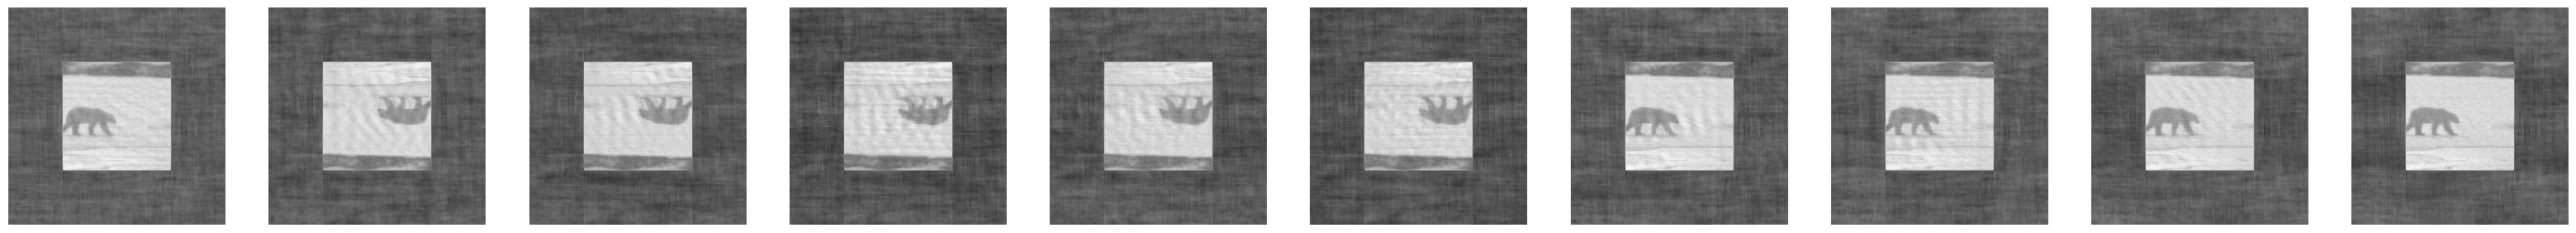

In [72]:
# visaulize result_final as subplots
result_final_viz = result_final.cpu().detach().numpy()
#subplots
fig, axs = plt.subplots(1, top_k, figsize=(40, 40))
for i in range(top_k):
    axs[i].imshow(result_final_viz[0][i], cmap="gray")
    axs[i].axis("off")

In [73]:
result_after_more_hio = get_algorithm("HIO")(
    amplitude, support, iterations, initial_value=result_final, use_tqdm=use_tqdm
)

/hdd_mnt/onurcan/onurk/utils/algorithms.py:85: UserWarning: Using a target size (torch.Size([10, 1, 512, 512])) that is different to the input size (torch.Size([10, 10, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = mse_loss(G.abs(), amplitude)
/hdd_mnt/onurcan/onurk/utils/algorithms.py:92: UserWarning: Using a target size (torch.Size([10, 1, 512, 512])) that is different to the input size (torch.Size([10, 10, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss(G.abs(), amplitude)


In [52]:
result_after_more_hio[0].shape

torch.Size([10, 13, 512, 512])

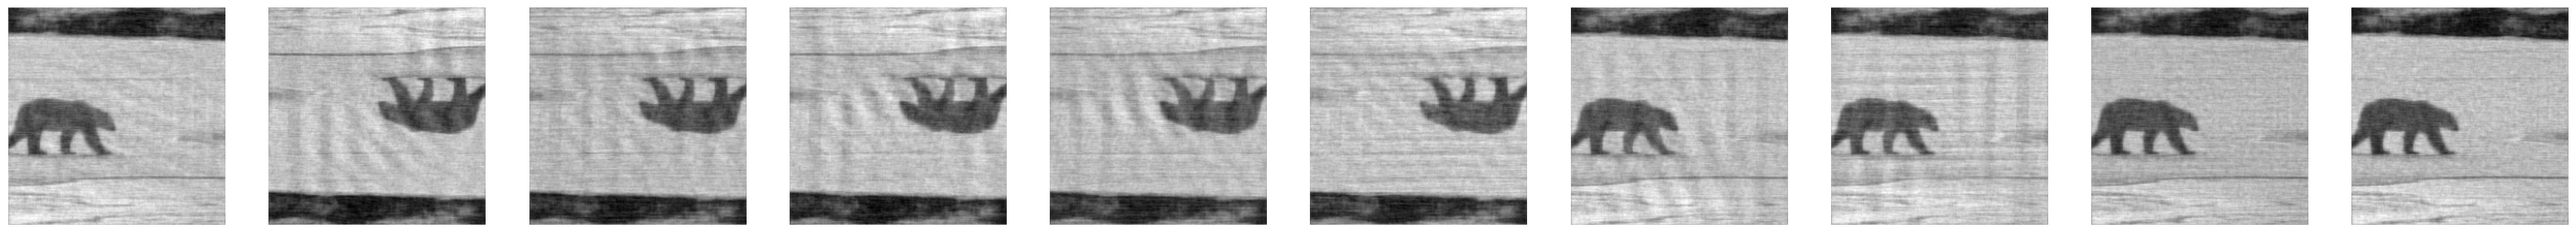

In [74]:
# visaulize result_final as subplots
result_after_more_hio_viz = result_after_more_hio[0].cpu().detach().numpy()
#subplots
fig, axs = plt.subplots(1, top_k, figsize=(40, 40))
for i in range(top_k):
    axs[i].imshow(crop_center_half(result_after_more_hio_viz[0][i]), cmap="gray")
    axs[i].axis("off")